In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
sns.set(style='white', context='notebook', palette='deep')

C:\Users\wang\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#load the data

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
print(len(test_df), len(train_df))
train_df.values.shape

28000 42000


(42000, 785)

In [4]:
label = train_df['label']
train_df = train_df.drop(train_df.columns[0], axis=1)
label.value_counts()


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [5]:
#no missing values in either training or testing set

print('Training set null value:{0}'.format(np.sum(np.sum(train_df.isnull()))))
print('Test set null value:{0}'.format(np.sum(np.sum(test_df.isnull()))))

Training set null value:0
Test set null value:0


In [6]:
# Normalize the data
train_df = train_df /255.0
test_df = test_df /255.0

In [7]:
#reshape the image np array into 4 dims 
train_df = train_df.values.reshape(-1,28,28,1)
test_df = test_df.values.reshape(-1,28,28,1)

In [8]:
print(train_df.shape, test_df.shape)

(42000, 28, 28, 1) (28000, 28, 28, 1)


In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

class LabelOneHotEncoder():
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit_transform(self, x):
        features = self.le.fit_transform( x)
        return self.ohe.fit_transform( features.reshape(-1,1))
    def transform( self, x):
        return self.ohe.transform( self.la.transform( x.reshape(-1,1)))
    def inverse_transform( self, x):
        return self.le.inverse_transform( self.ohe.inverse_transform( x))
    def inverse_labels( self, x):
        return self.le.inverse_transform( x)

lohe = LabelOneHotEncoder()
label_cat = lohe.fit_transform(label)


In [10]:
label_cat

<42000x10 sparse matrix of type '<class 'numpy.float64'>'
	with 42000 stored elements in Compressed Sparse Row format>

In [11]:
#train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(train_df, label, test_size = 0.1, random_state=10)

In [12]:
print('X_train.shape: ', X_train.shape)
print('Y_train.shape: ', Y_train.shape)
print('X_val.shape: ', X_val.shape)
print('Y_val.shape: ', Y_val.shape)

X_train.shape:  (37800, 28, 28, 1)
Y_train.shape:  (37800,)
X_val.shape:  (4200, 28, 28, 1)
Y_val.shape:  (4200,)


In [13]:
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)

In [14]:
X_train_vec = X_train.reshape([X_train.shape[0], -1])
Y_train = Y_train.reshape(-1)
print(X_train_vec.shape, Y_train.shape)

(37800, 784) (37800,)


In [15]:
from imblearn.over_sampling import SMOTE

smt=SMOTE(ratio='auto', random_state=10, k=None, k_neighbors=5, m=None, m_neighbors=10, out_step=0.5, kind='regular', svm_estimator=None, n_jobs=-1)
#SMOTE
X_train_af, Y_train_af=smt.fit_sample(X_train_vec, Y_train)

In [16]:
#balanced labels after SMOTE

print(pd.Series(Y_train_af).value_counts())

9    4216
8    4216
7    4216
6    4216
5    4216
4    4216
3    4216
2    4216
1    4216
0    4216
dtype: int64


In [17]:
#One-hot encoding to sparse matrices for label
Y_val = lohe.fit_transform(Y_val)

In [18]:
print(Y_train.shape)

(42160, 10)


In [19]:
#reshape to 4 dimensional array for CNN input
X_train = X_train_af.reshape(-1,28,28,1)

In [55]:
X_train.shape[0]

42160

In [130]:
#Data Augmentation using manual transformation (Input X_train)

import random
import numpy as np
from scipy.ndimage import affine_transform
from keras.preprocessing.image import img_to_array

#the mean aspect ratio
anisotropy = 2.15

def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    rotation        = np.deg2rad(rotation)
    shear           = np.deg2rad(shear)
    rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix    = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix     = np.array([[1.0/height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

# Compute the coordinate transformation required to center the pictures
def center_transform(affine, input_shape):
    hi, wi = float(input_shape[0]), float(input_shape[1])
    ho, wo = float(img_shape[0]), float(img_shape[1])
    top, left, bottom, right = 0, 0, hi, wi
    if wi/hi/anisotropy < wo/ho: # input image too narrow, extend width
        w     = hi*wo/ho*anisotropy
        left  = (wi-w)/2
        right = left + w
    else: # input image too wide, extend height
        h      = wi*ho/wo/anisotropy
        top    = (hi-h)/2
        bottom = top + h
    center_matrix   = np.array([[1, 0, -ho/2], [0, 1, -wo/2], [0, 0, 1]])
    scale_matrix    = np.array([[(bottom - top)/ho, 0, 0], [0, (right - left)/wo, 0], [0, 0, 1]])
    decenter_matrix = np.array([[1, 0, hi/2], [0, 1, wi/2], [0, 0, 1]])
    return np.dot(np.dot(decenter_matrix, scale_matrix), np.dot(affine, center_matrix))

# Apply an affine transformation to an image represented as a numpy array.
def transform_img(x, affine):
    matrix   = affine[:2,:2]
    offset   = affine[:2,2]
    x        = np.moveaxis(x, -1, 0)
    channels = [affine_transform(channel, matrix, offset, output_shape=img_shape[:-1], order=1,
                                 mode='constant', cval=np.average(channel)) for channel in x]
    return np.moveaxis(np.stack(channels, axis=0), 0, -1)

# Read an image for training, i.e. including a random affine transformation
def Training_data_preprocess(x):
    
    t  = build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.9, 1.0),
            random.uniform(0.9, 1.0),
            random.uniform(-0.05*img_shape[0], 0.05*img_shape[0]),
            random.uniform(-0.05*img_shape[1], 0.05*img_shape[1]))
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x  

# Read an image for validation, i.e. without data augmentation.
def Validation_data_preprocess(x):
    
    t  = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x

In [132]:

def Generator():
    #set data augmentation size = aug_batch_size*len(X_train) 
    aug_batch_size = 5

    #initiate matrix for data augmentation and transfermation
    X_train_transf = np.zeros((aug_batch_size * len(X_train), len(X_train[0]), len(X_train[0,0]), 1))
    Y_train_transf = np.zeros((aug_batch_size * Y_train_af.shape[0]))


    j = 0
    for i in range(len(X_train)):
        for _ in range(aug_batch_size):

            X_train_transf[j,:,:,:] = Training_data_preprocess(X_train[i])
            Y_train_transf[j] = Y_train_af[i]
            j+=1
    #One-hot encoding to sparse matrices for label
    Y_train_transf = lohe.fit_transform(Y_train_transf)
    return X_train_transf, Y_train_transf
    
    
    
#validation data preprocessing
X_val_transf = np.zeros(X_val.shape)
for i in range(len(X_val)):
    X_val_transf[i,:,:,:] = Validation_data_preprocess(X_val[i])

In [125]:
X_train_transf, Y_train_transf = Generator()

#Data augmentation Using ImageDataGenerator (Input X_train)

image_gen = ImageDataGenerator(
        '''
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=False,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = False, # Randomly zoom image 
        width_shift_range=False,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=False,  # randomly shift images vertically (fraction of total height)
        shear_range=False,
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False  # randomly flip images
        '''
        )

image_gen.fit(X_train_transf)


In [126]:
X_train_transf.shape

(210800, 28, 28, 1)

In [ ]:
#Building regular CNN

from keras.engine.topology import Input
from keras.layers import BatchNormalization, Concatenate, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam

img_shape  = (28,28,1)

def build_model():
    kwargs     = {'activation':'relu', 'padding':'same'}

    inp        = Input(shape=img_shape)

    x = inp

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    
    x = Dense(10, activation='softmax')(x)
                     
    return Model(inp,x)

model = build_model()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
# Fit the model
history =model.fit_generator(image_gen.flow(X_train, Y_train.toarray(),
          batch_size=batch_size),
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, Y_val.toarray()),
                            steps_per_epoch=33600 // batch_size)
score = model.evaluate(x_test, y_test, verbose=0)

In [53]:
#Building ResNet CNN
from keras import backend as K
from keras.engine.topology import Input
from keras.layers import Activation, BatchNormalization, Concatenate, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Add
from keras.models import Model
from keras.optimizers import Adam

img_shape  = (28,28,1)


def subblock(x, filter, **kwargs):
    x = BatchNormalization()(x)
    y = x
    y = Conv2D(filter, (2, 2), **kwargs)(y) # Reduce the number of features to 'filter'
    y = BatchNormalization()(y)
    y = Conv2D(filter, (3, 3), **kwargs)(y) # Extend the feature field
    y = BatchNormalization()(y)
    y = Conv2D(K.int_shape(x)[-1], (1, 1), **kwargs)(y) # no activation # Restore the number of original features
    y = Add()([x,y]) # Add the bypass connection
    y = Activation('relu')(y)
    return y

def build_model():
    
    kwargs = {'activation':'relu','padding':'same'}

    inp = Input(shape=img_shape) # 28x28x1
    x   = Conv2D(64, (2,2), strides=2, **kwargs)(inp)

    
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3,3), **kwargs)(x)

    
    x = BatchNormalization()(x)
    x = Conv2D(64, (2,2), **kwargs)(x)
    for _ in range(2): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = BatchNormalization()(x)
    x = Conv2D(64, (2,2), **kwargs)(x) 
    for _ in range(2): x = subblock(x, 64, **kwargs)

     
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), **kwargs)(x) 
    for _ in range(2): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), **kwargs)(x)
    for _ in range(2): x = subblock(x, 64, **kwargs)
     
    x             = Flatten()(x)
    
    x             = Dense(128, activation='relu')(x)
    x             = Dropout(0.25)(x)
    
    x             = Dense(10, activation='softmax')(x)
    
    return Model(inp,x)

model = build_model()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_139 (Conv2D)             (None, 14, 14, 64)   320         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_131 (BatchN (None, 14, 14, 64)   256         conv2d_139[0][0]                 
__________________________________________________________________________________________________
conv2d_140 (Conv2D)             (None, 14, 14, 64)   36928       batch_normalization_131[0][0]    
__________________________________________________________________________________________________
batch_norm

In [133]:
# Fit the ResNet CNN

epochs = 60
batch_size = 86

history =model.fit_generator(image_gen.flow(X_train_transf, Y_train_transf.toarray(), batch_size = batch_size) ,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_transf, Y_val.toarray()), steps_per_epoch = X_train_transf.shape[0]//batch_size)
                            
score = model.evaluate(X_val, Y_val, verbose=0)

Epoch 1/60
2451/2451 [==============================] - 81s 33ms/step - loss: 0.0197 - acc: 0.9938 - val_loss: 0.0376 - val_acc: 0.9910
Epoch 2/60
2451/2451 [==============================] - 82s 33ms/step - loss: 0.0165 - acc: 0.9949 - val_loss: 0.0251 - val_acc: 0.9936
Epoch 3/60
2451/2451 [==============================] - 82s 33ms/step - loss: 0.0132 - acc: 0.9959 - val_loss: 0.0227 - val_acc: 0.9938
Epoch 4/60
2451/2451 [==============================] - 82s 33ms/step - loss: 0.0115 - acc: 0.9965 - val_loss: 0.0328 - val_acc: 0.9926
Epoch 5/60
2451/2451 [==============================] - 82s 33ms/step - loss: 0.0100 - acc: 0.9969 - val_loss: 0.0318 - val_acc: 0.9938
Epoch 6/60
2451/2451 [==============================] - 82s 33ms/step - loss: 0.0090 - acc: 0.9972 - val_loss: 0.0375 - val_acc: 0.9898
Epoch 7/60
2451/2451 [==============================] - 82s 33ms/step - loss: 0.0088 - acc: 0.9972 - val_loss: 0.0291 - val_acc: 0.9931
Epoch 8/60
2451/2451 [==========================

In [ ]:
from keras.models import load_model
model1 = load_model('C:/Users/wang/Desktop/audio/digit.model')



NameError: name 'history' is not defined

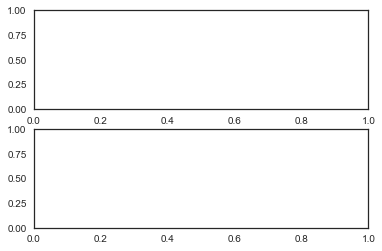

In [113]:

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [168]:
#testing data preprocessing
X_test_transf = np.zeros(test_df.shape)
for i in range(len(test_df)):
    X_test_transf[i,:,:,:] = Validation_data_preprocess(test_df[i])

# predict results
results_0 = model.predict(X_test_transf)

# select the indix with the maximum probability
results = np.argmax(results_0,axis = 1)

submission = pd.DataFrame(np.arange(1,28001),columns=["ImageId"])
submission['Label'] = results
submission.to_csv("MNIST_Sirui.csv",index=False)